# LDLS Demo

This notebook demonstrates how to use LDLS to perform instance segmentation of a LiDAR point cloud. This demo uses Frame 571 from the KITTI object detection dataset.

## Setup

Import LiDAR segmentation modules:

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from pathlib import Path
import skimage

from lidar_segmentation.detections import MaskRCNNDetections
from lidar_segmentation.segmentation import LidarSegmentation
from lidar_segmentation.kitti_utils import load_kitti_lidar_data, load_kitti_object_calib
from lidar_segmentation.utils import load_image
from mask_rcnn.mask_rcnn import MaskRCNNDetector


# Load input data

Load the following files:
- Calibration data (relates the LiDAR and camera sensor coordinate frames)
- Image
- LiDAR point cloud

Loaded LiDAR point cloud with 123131 points


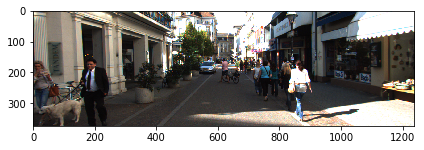

In [6]:
# Define file paths
calib_path = Path("data/") / "kitti_demo" / "calib" / "000571.txt"
image_path = Path("data/") / "kitti_demo" / "image_2" / "000571.png"
lidar_path = Path("data/") / "kitti_demo" / "velodyne" / "000571.bin"

# Load calibration data
projection = load_kitti_object_calib(calib_path)

# Load image
image = load_image(image_path)
skimage.io.imshow(image)

# Load lidar
lidar = load_kitti_lidar_data(lidar_path, load_reflectance=False)
print("Loaded LiDAR point cloud with %d points" % lidar.shape[0])

# Run Mask-RCNN detector on image

The first step in the LDLS pipeline is to run Mask-RCNN on the input image to generate 2D segmentation masks. The following code block runs Mask-RCNN and visualizes results on the input image.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/BrianWang/.virtualenvs/ldls/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


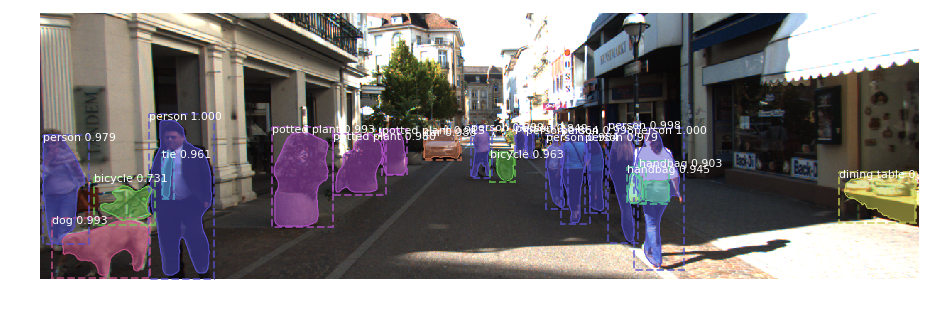

In [7]:
detector = MaskRCNNDetector()
detections = detector.detect(image)
detections.visualize(image)

# Perform LiDAR segmentation

Next, perform 3D segmentation using a LidarSegmentation object. The LidarSegmentation.run() method takes as inputs a LiDAR point cloud, Mask-RCNN detections, and a maximum number of iterations parameter.

In [9]:
lidarseg = LidarSegmentation(projection)
results = lidarseg.run(lidar, detections, max_iters=100)

# Visualize results

Visualization requires installing the [Point Processing Toolkit (pptk)](https://github.com/heremaps/pptk).

``
pip install pptk
``

Run the following code to open the visualizer.

In [31]:
import pptk
from colorsys import hsv_to_rgb



# close point cloud viewer if it is already open
try:
    viewer.close()
except NameError:
    pass

# define colors for results
n_instances = np.max(results.instance_labels())
hues = np.linspace(0,1, n_instances+1)
np.random.shuffle(hues)
inst_colors = np.array([hsv_to_rgb(h, 0.7, 0.85) for h in hues])
inst_colors[0,:] = [0.4, 0.4, 0.4]

all_classes, cls_indices = np.unique(results.class_labels(), return_inverse=True)
n_classes = len(all_classes)
hues = np.linspace(0,1, n_classes)
np.random.shuffle(hues)
cls_colors = np.array([hsv_to_rgb(h, 0.7, 0.85) for h in hues])
cls_colors[0,:] = [0.4, 0.4, 0.4]

# start the point cloud viewer
viewer = pptk.viewer(results.points)
viewer.set(point_size=0.01, show_axis=False, bg_color_bottom=[0.1,0.1,0.1,0.5])
viewer.attributes(inst_colors[results.instance_labels(), :], cls_colors[cls_indices, :])

With the pptk visualizer open, use the `[` and `]` keys to switch between coloring points based on instance labels (e.g. 'Person 1', 'Person 2', 'Car 1', ...), and class labels (e.g. 'Person', 'Car', 'Dog', ...).